In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision import transforms as T
from matplotlib import pyplot as plt
from torch import nn
from tqdm.auto import tqdm
import torchvision.utils as vutils

transform = T.Compose([T.Resize(32),
                       T.ToTensor()])
dataset = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transform
)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
num_epochs = 3
num_workers = 2 # 사용하는 CPU
batch_size = 128
nz = 100  # Size of z latent vector (i.e. size of generator input) 노이즈의 채널
ngf = 64  # Size of feature maps in generator 중간 기준 값
ndf = 64  # Size of feature maps in discriminator 

# Spatial size of training images. All images will be resized to this
#   size using transforms.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 1

device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
print(device)

cuda:0


  0%|          | 0/938 [00:00<?, ?it/s]

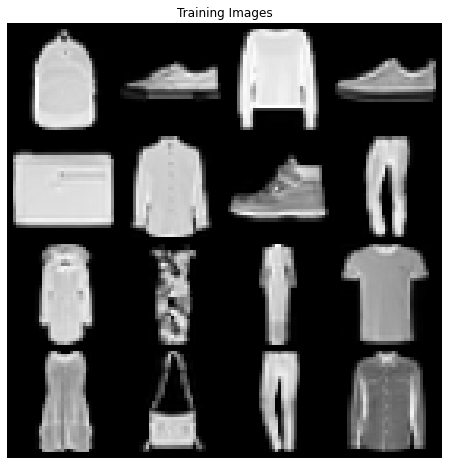

In [ ]:
for i, (image, _) in enumerate(tqdm(dataloader)):
  # Plot some training images
  plt.figure(figsize=(8,8))
  plt.axis("off")
  plt.title("Training Images")
  plt.imshow(vutils.make_grid(image[:16], padding=2, normalize=True, nrow=4).permute(1,2,0))
  break

In [ ]:
print(image.min(), image.max())

tensor(0.) tensor(0.9961)


In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. 4 x 4
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2), # stride 2
            nn.ReLU(True),
            # state size. 8 x 8
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False), # stride 2
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. 16 x 16
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

netG = Generator().to(device)
print(netG)


Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)


In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.ModuleList([
            # input is (nc) x 32 x 32
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 16 x 16
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        ])

    def forward(self, x):
        for layer in self.main:
          x = layer(x)
        return x

netD = Discriminator().to(device)
print(netD)


Discriminator(
  (main): ModuleList(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
)


In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device) 
# fixed_noise = generator에 어떤 결과가 나오는지 보는데, iternation이 가면서 노이즈를 고정하고 고정된 노이즈를 포워딩하면서 바뀌는 이미지를 보는 것

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = torch.optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
print("2021452013 김문엽")
# print your ID and name
# ...
# e.g., print("20221234567 youngjung uh")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, (image, _) in enumerate(tqdm(dataloader)):
        image = image.to(device)
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        
        netD.zero_grad()
        bs = image.size(0)
        label = torch.full((bs,), real_label, dtype=torch.float, device=device)
        output = netD(image).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(bs, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        # ...

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label) # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 100 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
2021452013 김문엽


  0%|          | 0/938 [00:00<?, ?it/s]

[0/3][0/938]	Loss_D: 1.2122	Loss_G: 0.7559	D(x): 0.5874	D(G(z)): 0.4801 / 0.4801
[0/3][50/938]	Loss_D: 5.1164	Loss_G: 0.0105	D(x): 0.5936	D(G(z)): 0.9895 / 0.9895
[0/3][100/938]	Loss_D: 5.7655	Loss_G: 0.0055	D(x): 0.5901	D(G(z)): 0.9945 / 0.9945
[0/3][150/938]	Loss_D: 6.0220	Loss_G: 0.0040	D(x): 0.6176	D(G(z)): 0.9960 / 0.9960
[0/3][200/938]	Loss_D: 6.2924	Loss_G: 0.0032	D(x): 0.5897	D(G(z)): 0.9968 / 0.9968
[0/3][250/938]	Loss_D: 6.5046	Loss_G: 0.0026	D(x): 0.5893	D(G(z)): 0.9974 / 0.9974
[0/3][300/938]	Loss_D: 6.6824	Loss_G: 0.0022	D(x): 0.5911	D(G(z)): 0.9978 / 0.9978
[0/3][350/938]	Loss_D: 6.7742	Loss_G: 0.0019	D(x): 0.6150	D(G(z)): 0.9981 / 0.9981
[0/3][400/938]	Loss_D: 6.9320	Loss_G: 0.0016	D(x): 0.6096	D(G(z)): 0.9984 / 0.9984
[0/3][450/938]	Loss_D: 7.0354	Loss_G: 0.0015	D(x): 0.5969	D(G(z)): 0.9985 / 0.9985
[0/3][500/938]	Loss_D: 7.1131	Loss_G: 0.0013	D(x): 0.6216	D(G(z)): 0.9987 / 0.9987
[0/3][550/938]	Loss_D: 7.2579	Loss_G: 0.0012	D(x): 0.5997	D(G(z)): 0.9988 / 0.9988
[0/3][6

  0%|          | 0/938 [00:00<?, ?it/s]

[1/3][0/938]	Loss_D: 7.9767	Loss_G: 0.0006	D(x): 0.5982	D(G(z)): 0.9994 / 0.9994
[1/3][50/938]	Loss_D: 8.0574	Loss_G: 0.0005	D(x): 0.6007	D(G(z)): 0.9995 / 0.9995
[1/3][100/938]	Loss_D: 8.1207	Loss_G: 0.0005	D(x): 0.6121	D(G(z)): 0.9995 / 0.9995
[1/3][150/938]	Loss_D: 8.2214	Loss_G: 0.0005	D(x): 0.5910	D(G(z)): 0.9995 / 0.9995
[1/3][200/938]	Loss_D: 8.2669	Loss_G: 0.0004	D(x): 0.5916	D(G(z)): 0.9996 / 0.9996
[1/3][250/938]	Loss_D: 8.3289	Loss_G: 0.0004	D(x): 0.5902	D(G(z)): 0.9996 / 0.9996
[1/3][300/938]	Loss_D: 8.3636	Loss_G: 0.0004	D(x): 0.6110	D(G(z)): 0.9996 / 0.9996
[1/3][350/938]	Loss_D: 8.4138	Loss_G: 0.0004	D(x): 0.6068	D(G(z)): 0.9996 / 0.9996
[1/3][400/938]	Loss_D: 8.4606	Loss_G: 0.0004	D(x): 0.6045	D(G(z)): 0.9996 / 0.9996
[1/3][450/938]	Loss_D: 8.4977	Loss_G: 0.0003	D(x): 0.6144	D(G(z)): 0.9997 / 0.9997
[1/3][500/938]	Loss_D: 8.5970	Loss_G: 0.0003	D(x): 0.5912	D(G(z)): 0.9997 / 0.9997
[1/3][550/938]	Loss_D: 8.6066	Loss_G: 0.0003	D(x): 0.5954	D(G(z)): 0.9997 / 0.9997
[1/3][6

  0%|          | 0/938 [00:00<?, ?it/s]

[2/3][0/938]	Loss_D: 8.8809	Loss_G: 0.0002	D(x): 0.6111	D(G(z)): 0.9998 / 0.9998
[2/3][50/938]	Loss_D: 8.9611	Loss_G: 0.0002	D(x): 0.5800	D(G(z)): 0.9998 / 0.9998
[2/3][100/938]	Loss_D: 8.9403	Loss_G: 0.0002	D(x): 0.6110	D(G(z)): 0.9998 / 0.9998
[2/3][150/938]	Loss_D: 9.0005	Loss_G: 0.0002	D(x): 0.5997	D(G(z)): 0.9998 / 0.9998
[2/3][200/938]	Loss_D: 8.9780	Loss_G: 0.0002	D(x): 0.6208	D(G(z)): 0.9998 / 0.9998
[2/3][250/938]	Loss_D: 9.0278	Loss_G: 0.0002	D(x): 0.6202	D(G(z)): 0.9998 / 0.9998
[2/3][300/938]	Loss_D: 9.0885	Loss_G: 0.0002	D(x): 0.5885	D(G(z)): 0.9998 / 0.9998
[2/3][350/938]	Loss_D: 9.1018	Loss_G: 0.0002	D(x): 0.6093	D(G(z)): 0.9998 / 0.9998
[2/3][400/938]	Loss_D: 9.1231	Loss_G: 0.0002	D(x): 0.6080	D(G(z)): 0.9998 / 0.9998
[2/3][450/938]	Loss_D: 9.1713	Loss_G: 0.0002	D(x): 0.5924	D(G(z)): 0.9998 / 0.9998
[2/3][500/938]	Loss_D: 9.1661	Loss_G: 0.0002	D(x): 0.6106	D(G(z)): 0.9998 / 0.9998
[2/3][550/938]	Loss_D: 9.2054	Loss_G: 0.0002	D(x): 0.6029	D(G(z)): 0.9998 / 0.9998
[2/3][6

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML

fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(i.permute(1,2,0), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

Output hidden; open in https://colab.research.google.com to view.